In [2]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=3366551 sha256=c48cc9096e6b310a4eadd591cd4a92cb7d89b0d619ae627b45e4ae0db4287f93
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [1]:
import pandas as pd
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
import scipy.sparse as sp


In [3]:
col_names = ['user_id', 'item_id', 'rating', 'title']

In [2]:
Luxury_Beauty_dataset = pd.read_csv('Luxury_Beauty_dataset.csv')

In [3]:
Luxury_Beauty_dataset.head()

,user_id,item_id,rating,title
0,A3HO2SQDCZIE9S,B00004U9V2,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
1,A3HO2SQDCZIE9S,B00004U9V2,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
2,A2EM03F99X3RJZ,B00004U9V2,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
3,A2EM03F99X3RJZ,B00004U9V2,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
4,A3Z74TDRGD0HU,B00004U9V2,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...


In [4]:
Luxury_Beauty_dataset.shape

(401164, 4)

In [5]:
user_purchase_counts = Luxury_Beauty_dataset.groupby('user_id')['item_id'].count()

In [6]:
users_with_more_than_10_purchases = user_purchase_counts[user_purchase_counts >= 5].index

In [7]:
df_filtered = Luxury_Beauty_dataset[Luxury_Beauty_dataset['user_id'].isin(users_with_more_than_10_purchases)]

In [8]:
df_filtered = df_filtered.drop_duplicates(['item_id', 'user_id'])

In [9]:
df_filtered.shape

(21819, 4)

In [10]:
df_filtered

,user_id,item_id,rating,title
138,A2HOI48JK8838M,B00004U9V2,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
320,A2QCGHIJ2TCLVP,B00004U9V2,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
358,A1606LA683WZZU,B00004U9V2,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
402,A1YY53NQXFKMRN,B00004U9V2,4.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
470,A3R0NQ9E53JHYQ,B00004U9V2,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
...,...,...,...,...
401069,A37NYXQ098PPIQ,B00DW6MV2Y,5.0,Eyeko Black Magic Mascara
401073,ANR73TPVBCQ9K,B00DW6MV2Y,5.0,Eyeko Black Magic Mascara
401099,AOT6PL9L9GQP3,B00DW6MV2Y,5.0,Eyeko Black Magic Mascara
401110,A29XI8QYHVHM7B,B00DW6MV2Y,3.0,Eyeko Black Magic Mascara


In [ ]:
# Построение рекомендательной модели с помощью алгоритма SVD из библиотеки Surprise

In [34]:
# Загрузка данных из Pandas DataFrame
data = Luxury_Beauty_dataset.copy()

# Определение формата файла
reader = Reader(rating_scale=(1, 5))

# Создание Surprise Dataset из Pandas DataFrame
surprise_data = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)

# Разбиение на тренировочный и тестовый наборы
trainset, testset = train_test_split(surprise_data, test_size=.25)

# Обучение модели
model = SVD(n_factors=150, n_epochs=15, lr_all=0.01, reg_all=0.2)
model.fit(trainset)

# Получение рекомендаций для всех пользователей
predictions = model.test(testset)

# Вывод рекомендаций для конкретного пользователя
user_id = 11
recommendations = []
for iid in data['item_id'].unique():
    if not data[(data['user_id'] == user_id) & (data['item_id'] == iid)].empty:
        continue
    est = model.predict(user_id, iid).est
    recommendations.append((iid, est))

# Сортировка рекомендаций по оценкам
recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)

# Получение названий объектов из их идентификаторов
item_name = dict(zip(data['item_id'], data['title']))

# Расчет метрик RMSE и MAE
rmse = accuracy.rmse(predictions, verbose=False)
mae = accuracy.mae(predictions, verbose=False)
print(rmse)
print(mae)

# Вывод рекомендаций
user_purchases = data[data['user_id'] == data.iloc[user_id]['user_id']]['title'].tolist()
print(f"Список покупок пользователя {user_id}:")
print('\n'.join(user_purchases), '\n')

print(f"Top 10 рекомендаций для пользователя {user_id}: ")
for i, (iid, est) in enumerate(recommendations[:10]):
    print(f"{i+1}. {item_name[iid]} (оценка: {round(est, 3)})")


'''
на отфильтрованном датасете по количеству покупок df_filtered (7428, 4)
1.0293248163460877
0.7704199813381933

на полном датасете такие результаты:
1.4644756587736585
0.7360680419977864
Список покупок пользователя 11:
Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ
Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ 

Top 10 рекомендаций для пользователя 11: 
1. Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ (оценка: 5)
2. Crabtree &amp; Evelyn Hand Soap, Gardeners, 10.1 fl. oz. (оценка: 5)
3. Soy Milk Hand Crme (оценка: 5)
4. Supersmile Powdered Mouthrinse (оценка: 5)
5. Supersmile Professional Teeth Whitening Toothpaste  Recommended By Cosmetic Dentists, CLINICALLY... (оценка: 5)
6. Archipelago Morning Mint Body Lotion ,18 Fl Oz (оценка: 5)
7. Calvin Klein ck one Eau de Toilette, 3.4 fl. oz. (оценка: 5)
8. Helen of Troy 1193 Professional Flat Iron (оценка: 5)
9. DERMAdoctor Calm, Cool &amp; Corrected anti-redness tranquility cream - 1.7 Oz (оценка: 5)
10. DERMAdoctor Total Nonscents Ultra-Gentle Brightening Antiperspirant, 3 fl. oz. (оценка: 5)
'''

1.4644756587736585
0.7360680419977864
Список покупок пользователя 11:
Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ
Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ 

Top 10 рекомендаций для пользователя 11: 
1. Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ (оценка: 5)
2. Crabtree &amp; Evelyn Hand Soap, Gardeners, 10.1 fl. oz. (оценка: 5)
3. Soy Milk Hand Crme (оценка: 5)
4. Supersmile Powdered Mouthrinse (оценка: 5)
5. Supersmile Professional Teeth Whitening Toothpaste  Recommended By Cosmetic Dentists, CLINICALLY... (оценка: 5)
6. Archipelago Morning Mint Body Lotion ,18 Fl Oz (оценка: 5)
7. Calvin Klein ck one Eau de Toilette, 3.4 fl. oz. (оценка: 5)
8. Helen of Troy 1193 Professional Flat Iron (оценка: 5)
9. DERMAdoctor Calm, Cool &amp; Corrected anti-redness tranquility cream - 1.7 Oz (оценка: 5)
10. DERMAdoctor Total Nonscents Ultra-Gentle Brightening Antiperspira

"\ndf_filtered (7428, 4)\n1.0293248163460877\n0.7704199813381933\n\nна полном датасете такие результаты:\n1.4524081275998697\n0.723495410712211\nСписок покупок пользователя 1: []\nTop 10 рекомендаций для пользователя 1: \n1. Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ (оценка: 5)\n2. Crabtree &amp; Evelyn Hand Soap, Gardeners, 10.1 fl. oz. (оценка: 5)\n3. Soy Milk Hand Crme (оценка: 5)\n4. Supersmile Powdered Mouthrinse (оценка: 5)\n5. Supersmile Professional Teeth Whitening Toothpaste  Recommended By Cosmetic Dentists, CLINICALLY... (оценка: 5)\n6. Archipelago Morning Mint Body Lotion ,18 Fl Oz (оценка: 5)\n7. Calvin Klein ck one Eau de Toilette, 3.4 fl. oz. (оценка: 5)\n8. Helen of Troy 1193 Professional Flat Iron (оценка: 5)\n9. DERMAdoctor Calm, Cool &amp; Corrected anti-redness tranquility cream - 1.7 Oz (оценка: 5)\n10. DERMAdoctor Total Nonscents Ultra-Gentle Brightening Antiperspirant, 3 fl. oz. (оценка: 5)\n"

In [12]:
surprise_data

In [10]:
# Построение рекомендательной модели с помощью алгоритма KNN из библиотеки Surprise

In [33]:
# К сожалению, обучать алгоритм KNN на полном датасете не получится, т.к. колаб крашится, поэтому буду обучать на отфильтрованном датасете
data = df_filtered.copy()
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)

# Разбиение на train/test
# trainset = surprise_data.build_full_trainset()

trainset, testset = train_test_split(surprise_data, test_size=.25)
sim_options = {'name': 'cosine',
               'user_based': True,
               'k':10,
               'min_k':8
              }

# Инициализация алгоритма
algo = KNNBasic(sim_options=sim_options)

# Обучение модели
algo.fit(trainset)

# Получение рекомендаций для пользователя с ID 11
user_id = 3
user_items = data[data['user_id'] == user_id]['item_id'].unique()
predictions = []
for item_id in data['item_id'].unique():
    if item_id not in user_items:
        predictions.append((item_id, algo.predict(user_id, item_id).est))
recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:10]

# Получение названий объектов из их идентификаторов
item_name = defaultdict(str)
for item_id in data['item_id'].unique():
    item_name[item_id] = data[data['item_id'] == item_id]['title'].iloc[0]

predictions = algo.test(testset)
# Расчет метрик RMSE и MAE
rmse = accuracy.rmse(predictions, verbose=False)
mae = accuracy.mae(predictions, verbose=False)
print(rmse)
print(mae,'\n') 

# Вывод рекомендаций
user_purchases = data[data['user_id'] == data.iloc[user_id]['user_id']]['title'].tolist()
print(f"Список покупок пользователя {user_id}:")
print('\n'.join(user_purchases), '\n')

print(f"Top 10 рекомендаций для пользователя {user_id}: ")
for item_id, est_rating in recommendations:
    print(f"{item_name[item_id]} (оценка: {est_rating})")

Computing the cosine similarity matrix...
Done computing similarity matrix.
1.176972858323677
0.8760053047940674 

Список покупок пользователя 3:
Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ
Revision Skincare Nectifirm, 1.7 oz
NEOCUTIS Lumi&egrave;re Bio-restorative Eye Cream, 0.5 Fl Oz
AHAVA Dead Sea Dermud Intensive Moisturizers
AHAVA Dead Sea Mineral Body Lotions 

Top 10 рекомендаций для пользователя 3: 
Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ (оценка: 4.3240039110241995)
Soy Milk Hand Crme (оценка: 4.3240039110241995)
Supersmile Powdered Mouthrinse (оценка: 4.3240039110241995)
Supersmile Professional Teeth Whitening Toothpaste  Recommended By Cosmetic Dentists, CLINICALLY... (оценка: 4.3240039110241995)
Archipelago Morning Mint Body Lotion ,18 Fl Oz (оценка: 4.3240039110241995)
Calvin Klein ck one Eau de Toilette, 3.4 fl. oz. (оценка: 4.3240039110241995)
Helen of Troy 1193 Professional Flat Iron

In [38]:
# попробуем поработать с библиотекой lightfm

In [35]:
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.1/310.1 KB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.16-cp38-cp38-linux_x86_64.whl size=917985 sha256=9d5506cea9efb54842a58b0f78de560af1dae38f6d1f83bb5f539115047dcd3c
  Stored in directory: /root/.cache/pip/wheels/ec/bb/51/9c487d021c1373b691d13cadca0b65b6852627b1f3f43550fa
Successfully built lightfm


In [47]:
from lightfm import LightFM
from lightfm.data import Dataset as Dataset_LightFM
from lightfm.evaluation import precision_at_k
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix, csr_matrix
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import auc_score
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [45]:
# Загрузка данных из датасета
data = df_filtered.copy()

item_id_to_index = {}
index_to_item_id = {}
for index, item_id in enumerate(data['item_id'].unique()):
    item_id_to_index[item_id] = index
    index_to_item_id[index] = item_id

user_id_to_index = {}
index_to_user_id = {}
for index, user_id in enumerate(data['user_id'].unique()):
    user_id_to_index[user_id] = index
    index_to_user_id[index] = user_id

data['item_id'] = data['item_id'].apply(lambda x: item_id_to_index[x])
data['user_id'] = data['user_id'].apply(lambda x: user_id_to_index[x])

# Создание экземпляра класса Dataset
dataset = Dataset_LightFM()

# Преобразование user_id и item_id в числовой формат
dataset.fit(data['user_id'], data['item_id'])

# Разделение данных на обучающую и тестовую выборки
train_interactions, test_interactions = coo_matrix((data['rating'],
                                                    (data['user_id'], data['item_id']))), \
                                        coo_matrix((data['rating'],
                                                    (data['user_id'], data['item_id'])))

# Преобразование обучающей и тестовой выборок для работы с моделью LightFM
train = csr_matrix(train_interactions).tocoo()
test = csr_matrix(test_interactions).tocoo()

# Создание экземпляра модели и обучение на обучающей выборке
# model = LightFM(loss='warp')
model = LightFM(no_components=30,
                        loss='warp-kos',
                        learning_schedule='adagrad',
                        user_alpha=1e-3, item_alpha=1e-3)
model.fit(train, epochs=70)

# Оценка качества модели на тестовой выборке
precision = precision_at_k(model, test, k=5).mean()
print(f'Precision@5: {precision:.2f}')

# Генерация рекомендаций для новых пользователей
items_dict = dict(zip(data['item_id'], data['title']))
existing_item_ids = train.nonzero()[1]

user_ids = [1, 12, 23]
for user_id in user_ids:
    scores = model.predict(user_id, existing_item_ids)
    top_items = sorted(zip(existing_item_ids, scores), key=lambda x: -x[1])[:3]
    print(f'Recommendations for user {user_id}:')
    for item_id, score in top_items:
        print(f'- {items_dict[item_id]} (score: {score:.2f})')


Precision@5: 0.70
Recommendations for user 1:
- Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ (score: 1.13)
- Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ (score: 1.13)
- Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ (score: 1.13)
Recommendations for user 12:
- Dermablend Cover Creme Full Coverage Foundation with SPF 30, 1 Oz (score: 0.88)
- Dermablend Cover Creme Full Coverage Foundation with SPF 30, 1 Oz (score: 0.88)
- Dermablend Cover Creme Full Coverage Foundation with SPF 30, 1 Oz (score: 0.88)
Recommendations for user 23:
- Supersmile Professional Teeth Whitening Toothpaste  Recommended By Cosmetic Dentists, CLINICALLY... (score: 0.93)
- Supersmile Professional Teeth Whitening Toothpaste  Recommended By Cosmetic Dentists, CLINICALLY... (score: 0.93)
- Supersmile Professional Teeth Whitening Toothpaste  Recommended By Cosmetic Dentists, CLINICALLY... (score: 0.

In [ ]:
# прогоним тюнинг, как показано в примере из библиотеки

In [19]:
alpha = 1e-3
epochs = 70

adagrad_model = LightFM(no_components=30,
                        loss='warp',
                        learning_schedule='adagrad',
                        user_alpha=alpha,
                        item_alpha=alpha)
adadelta_model = LightFM(no_components=30,
                        loss='warp',
                        learning_schedule='adadelta',
                        user_alpha=alpha,
                        item_alpha=alpha)

adagrad_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(train, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, test).mean())


adadelta_auc = []

for epoch in range(epochs):
    adadelta_model.fit_partial(train, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, test).mean())

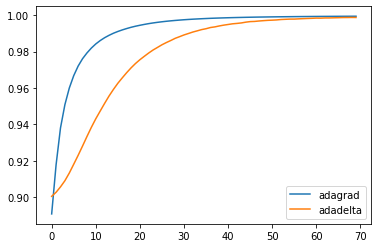

In [21]:
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()

In [22]:
alpha = 1e-3
epochs = 70

adagrad_model = LightFM(no_components=30,
                        loss='warp-kos',
                        learning_schedule='adagrad',
                        user_alpha=alpha, item_alpha=alpha)
adadelta_model = LightFM(no_components=30,
                        loss='warp-kos',
                        learning_schedule='adadelta',
                        user_alpha=alpha, item_alpha=alpha)

adagrad_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(train, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, test).mean())


adadelta_auc = []

for epoch in range(epochs):
    adadelta_model.fit_partial(train, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, test).mean())

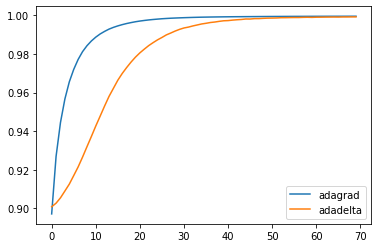

In [23]:
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()